In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import minimize

In [2]:
def kmh_to_ms(speed_kmh):
    return speed_kmh * (1000 / 3600)

# --- OVM model implementation ---
def optimal_velocity(s, s_st, vmax):
    """Optimal velocity function (can be sigmoid or linear)."""
    return vmax * np.tanh(s / s_st - 2)

def ovm_model(params, time, lead_speed, initial_spacing, initial_speed):
    vmax, alpha, s_st = params
    spacing = [initial_spacing]
    speed = [initial_speed]

    for t in range(1, len(time)):
        dt = time[t] - time[t - 1]
        s = spacing[-1]
        v = speed[-1]

        v_opt = optimal_velocity(s, s_st, vmax)
        a = alpha * (v_opt - v)

        # Euler integration
        v_new = max(v + a * dt, 0)
        s_new = max(s + (lead_speed[t - 1] - v) * dt, 0)

        speed.append(v_new)
        spacing.append(s_new)

    return np.array(spacing), np.array(speed)

# --- Objective function (RMSE between simulated and experimental spacing) ---
def objective_ovm(params, time, lead_speed, experimental_spacing, initial_spacing, initial_speed):
    simulated_spacing, _ = ovm_model(params, time, lead_speed, initial_spacing, initial_speed)
    rmse = np.sqrt(np.mean((simulated_spacing - experimental_spacing) ** 2))
    return rmse

# --- Calibration function ---
def calibrate_ovm(df, subset_duration=200, dt=0.02):
    subset_length = int(subset_duration / dt)
    num_subsets = 6
    subsets = [df.iloc[i * subset_length:(i + 1) * subset_length] for i in range(num_subsets)]

    best_rmse = np.inf
    best_params = None

    for i, subset in enumerate(subsets):
        print(f"\n--- Calibrating on subset {i + 1}/{num_subsets} ---")

        time = subset['Time'].values
        lead_speed = subset['Speed Leader'].values
        spacing = subset['Spacing'].values
        follower_speed = subset['Speed Follower'].values

        initial_spacing = spacing[0]
        initial_speed = follower_speed[0]

        initial_params = [20.0, 0.5, 10.0]  # [vmax, alpha, s_st]
        bounds = [(5, 35), (0.1, 2.0), (5.0, 20.0)]

        result = minimize(objective_ovm, initial_params,
                          args=(time, lead_speed, spacing, initial_spacing, initial_speed),
                          bounds=bounds, method='L-BFGS-B')

        rmse = objective_ovm(result.x, time, lead_speed, spacing, initial_spacing, initial_speed)
        print(f"Subset {i + 1} RMSE: {rmse:.4f}")
        print(f"Params: {result.x}")

        if rmse < best_rmse:
            best_rmse = rmse
            best_params = result.x

    print("\n--- Best Calibration Results ---")
    print(f"Best Params: {best_params}")
    print(f"Best RMSE: {best_rmse:.4f}")
    return best_params



In [3]:
# --- Evaluation and Plotting ---
def simulate_and_plot_ovm(df, best_params, model_name="OVM", report_path="./", limit=None):
    time = df['Time'].values
    lead_speed = df['Speed Leader'].values
    follower_speed = df['Speed Follower'].values
    spacing = df['Spacing'].values

    simulated_spacing, simulated_speed = ovm_model(best_params, time, lead_speed, spacing[0], follower_speed[0])
    rmse = np.sqrt(np.mean((simulated_spacing - spacing) ** 2))
    print(f"\nFull Dataset RMSE: {rmse:.4f}")

    if limit is not None:
        start, end = limit
        mask = (time >= start) & (time <= end)
        time = time[mask]
        spacing = spacing[mask]
        simulated_spacing = simulated_spacing[mask]
        follower_speed = follower_speed[mask]
        simulated_speed = simulated_speed[mask]
        lead_speed = lead_speed[mask]

    plt.figure(figsize=(12, 6))
    plt.plot(time, spacing, label='Experimental Spacing', color='blue')
    plt.plot(time, simulated_spacing, label='Simulated Spacing', color='red', linestyle='--')
    plt.xlabel('Time (s)')
    plt.ylabel('Spacing (m)')
    plt.title(f'Spacing Comparison - {model_name}')
    plt.legend()
    plt.grid(True)
    plt.savefig(f"{report_path}{model_name}_spacing.png")
    plt.show()

    plt.figure(figsize=(12, 6))
    plt.plot(time, follower_speed, label='Experimental Follower Speed', color='blue')
    plt.plot(time, simulated_speed, label='Simulated Follower Speed', color='red', linestyle='--')
    plt.plot(time, lead_speed, label='Leader Speed', color='green', linestyle=':')
    plt.xlabel('Time (s)')
    plt.ylabel('Speed (m/s)')
    plt.title(f'Speed Comparison - {model_name}')
    plt.legend()
    plt.grid(True)
    plt.savefig(f"{report_path}{model_name}_speed.png")
    plt.show()



In [4]:
def test_and_viz_full_dataset(df, best_params,model_name,report_path, limit=None):
    # Extract relevant columns
    time = np.arange(0, len(df) * 0.02, 0.02)  # Assuming time increments by 0.02 seconds
    #     time = df['Time'].values
    lead_speed = df['Speed Leader'].values
    follow_speed = df['Speed Follower'].values
    experimental_spacing = df['Spacing'].values  # Assuming this is the spacing

    # Test the best model on the entire dataset
    # simulated_spacing_full, simulated_speed_full = idm_model(best_params, time, lead_speed, experimental_spacing[0],
    #                                                          follow_speed[0])
    simulated_spacing_full, simulated_speed_full = ovm_model(best_params, time, lead_speed, experimental_spacing[0],
                                                             follow_speed[0])
    rmse_full = np.sqrt(np.mean((simulated_spacing_full - experimental_spacing) ** 2))
    print("-----------------------------------------------------------------------------")
    print(f"Full dataset RMSE: {rmse_full:.4f}")

    # Apply the limit to the data
    if limit is not None:
        start, end = limit
        mask = (time >= start) & (time <= end)
        time = time[mask]
        experimental_spacing = experimental_spacing[mask]
        simulated_spacing_full = simulated_spacing_full[mask]
        follow_speed = follow_speed[mask]
        simulated_speed_full = simulated_speed_full[mask]
        lead_speed = lead_speed[mask]

    # Visualize the results
    import matplotlib.pyplot as plt

    # Plot simulated vs experimental spacing
    plt.figure(figsize=(12, 6))
    plt.plot(time, experimental_spacing, label='Experimental Spacing', color='blue', linestyle='-', linewidth=1)
    plt.plot(time, simulated_spacing_full, label='Simulated Spacing', color='red', linestyle='-', linewidth=1)
    plt.xlabel('Time (s)')
    plt.ylabel('Spacing (m)')
    plt.title(f'Simulated vs Experimental Spacing of {model_name}')
    plt.legend()
    plt.grid(True)
    plt.savefig(f"{report_path}{model_name}_spacing.png")
    plt.show()

    # Plot simulated vs experimental speed (including leader speed)
    plt.figure(figsize=(12, 6))
    plt.plot(time, follow_speed, label='Experimental Follower Speed', color='blue', linestyle='-', linewidth=1)
    plt.plot(time, simulated_speed_full, label='Simulated Follower Speed', color='red', linestyle='-', linewidth=1)
    plt.plot(time, lead_speed, label='Leader Speed', color='green', linestyle='-', linewidth=2)
    plt.xlabel('Time (s)')
    plt.ylabel('Speed (m/s)')
    plt.title(f'Simulated vs Experimental Speed of {model_name}')
    plt.legend()
    plt.grid(True)
    plt.savefig(f"{report_path}{model_name}_speed.png")
    plt.show()


--- Calibrating on subset 1/6 ---
Subset 1 RMSE: 5.0435
Params: [26.91234308  0.97247797  8.36628783]

--- Calibrating on subset 2/6 ---
Subset 2 RMSE: 11.7286
Params: [35.          2.          9.33602025]

--- Calibrating on subset 3/6 ---
Subset 3 RMSE: 3.5158
Params: [21.87528606  0.81679798  9.43261956]

--- Calibrating on subset 4/6 ---
Subset 4 RMSE: 5.2608
Params: [27.95226417  1.09280013 11.57706621]

--- Calibrating on subset 5/6 ---
Subset 5 RMSE: 5.2076
Params: [28.40061087  2.         11.86514228]

--- Calibrating on subset 6/6 ---
Subset 6 RMSE: 6.5460
Params: [32.58657809  1.12384959 12.00811611]

--- Best Calibration Results ---
Best Params: [21.87528606  0.81679798  9.43261956]
Best RMSE: 3.5158
-----------------------------------------------------------------------------
Full dataset RMSE: 53.6896


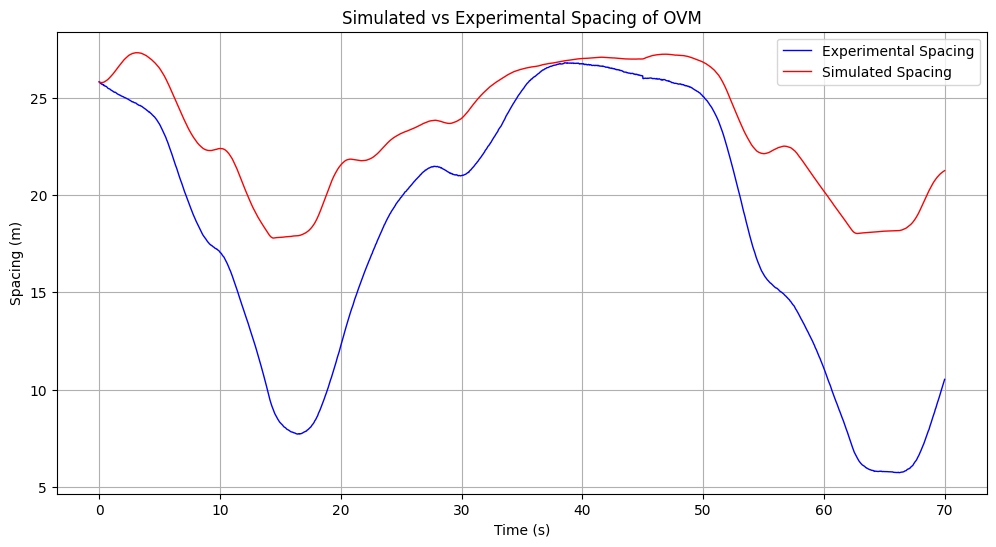

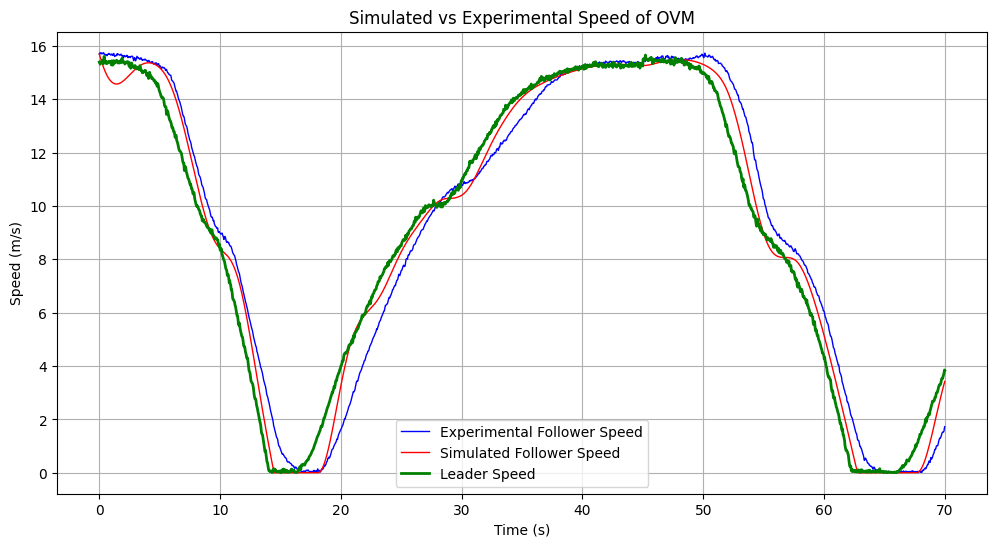

In [6]:

df = pd.read_csv("../data/combined_data.csv")
df['Speed Follower'] = kmh_to_ms(df['Speed Follower'])
df['Speed Leader'] = kmh_to_ms(df['Speed Leader'])

medium_gap_df = df[df['gap_setting'] == 'Medium']
best_params = calibrate_ovm(medium_gap_df)
test_and_viz_full_dataset(medium_gap_df, best_params, model_name="OVM", report_path="../REPORTS/OVM/", limit=(0, 70))



--- Calibrating on subset 1/6 ---
Subset 1 RMSE: 3.7173
Params: [16.70749676  0.5246676   7.8488176 ]

--- Calibrating on subset 2/6 ---
Subset 2 RMSE: 5.4721
Params: [22.36434276  1.16630512 10.00397574]

--- Calibrating on subset 3/6 ---
Subset 3 RMSE: 3.4262
Params: [21.69229734  1.48588134 10.63292029]

--- Calibrating on subset 4/6 ---
Subset 4 RMSE: 8.1458
Params: [33.45423709  0.55681128 14.25935856]

--- Calibrating on subset 5/6 ---
Subset 5 RMSE: 4.7565
Params: [26.47766768  0.75203065 12.38694214]

--- Calibrating on subset 6/6 ---
Subset 6 RMSE: 8.2887
Params: [28.52157172  0.7678597  12.89928836]

--- Best Calibration Results ---
Best Params: [21.69229734  1.48588134 10.63292029]
Best RMSE: 3.4262
-----------------------------------------------------------------------------
Full dataset RMSE: 63.0232


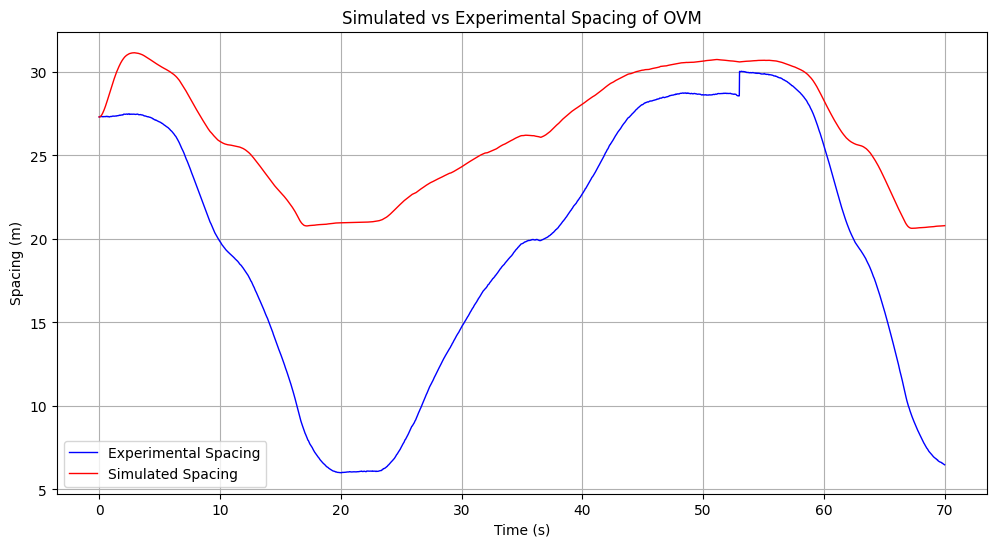

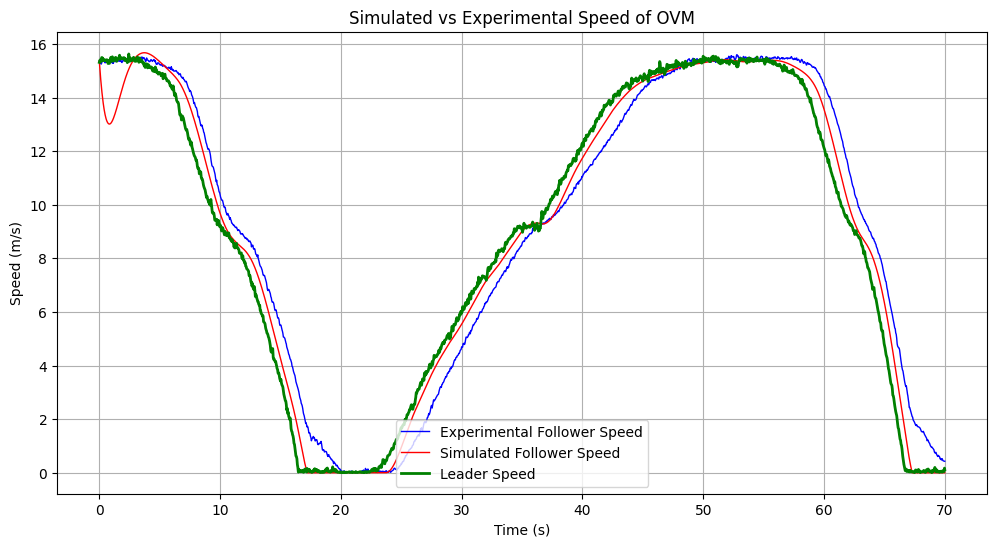

In [7]:
long_gap_df = df[df['gap_setting'] == 'Long']
best_params = calibrate_ovm(long_gap_df)
test_and_viz_full_dataset(long_gap_df, best_params, model_name="OVM", report_path="../REPORTS/OVM/", limit=(0, 70))



--- Calibrating on subset 1/6 ---
Subset 1 RMSE: 4.7162
Params: [16.21916628  0.43816092  8.88850287]

--- Calibrating on subset 2/6 ---
Subset 2 RMSE: 41.1209
Params: [19.86063387  0.29412617  9.7348121 ]

--- Calibrating on subset 3/6 ---
Subset 3 RMSE: 4.3535
Params: [21.78463052  0.54103049 12.73239463]

--- Calibrating on subset 4/6 ---
Subset 4 RMSE: 10.5232
Params: [28.67250494  2.         15.20693179]

--- Calibrating on subset 5/6 ---
Subset 5 RMSE: 5.6596
Params: [26.34369096  0.45879006 15.91489938]

--- Calibrating on subset 6/6 ---
Subset 6 RMSE: 9.9951
Params: [25.95279391  0.43407348 14.86947731]

--- Best Calibration Results ---
Best Params: [21.78463052  0.54103049 12.73239463]
Best RMSE: 4.3535
-----------------------------------------------------------------------------
Full dataset RMSE: 68.4731


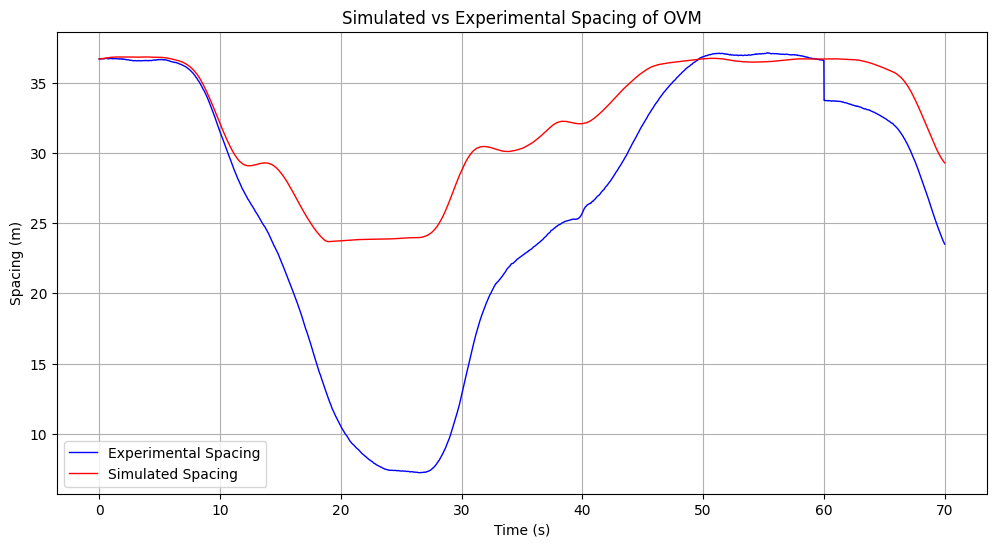

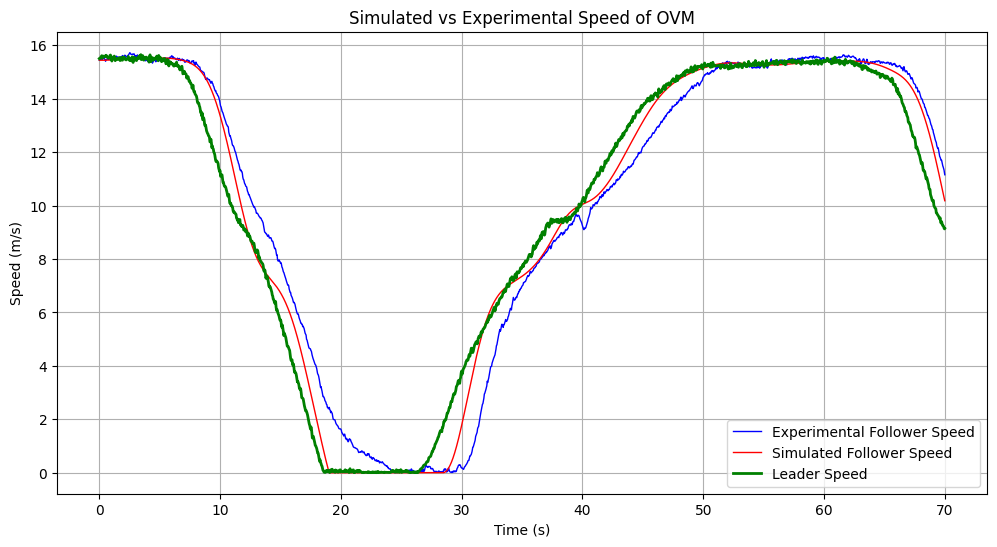

In [9]:
xlong_gap_df = df[df['gap_setting'] == 'XLong']
best_params = calibrate_ovm(xlong_gap_df)
test_and_viz_full_dataset(xlong_gap_df, best_params, model_name="OVM", report_path="../REPORTS/OVM/", limit=(0, 70))
